## 📊 RFM Analysis & Customer Segmentation in eCommerce

#### Project Description:
##### RFM (Recency, Frequency, Monetary) analysis applied on eCommerce sales data to segment customers into groups like Champions, Loyal Customers, and At-Risk Customers. This project includes data cleaning, feature engineering, customer segmentation, and predictive modeling using Decision Tree classifier.

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("Superstore_Data.csv")
df.head()

,Row ID,Order ID,Order Date,Year,Ship Date,Ship Mode,Customer ID,CxCode,Customer Name,Order ID.1,...,Category,Sub-Category,Products,Sales,Cx_Category,Quantity,Qty_Status,New_Discount,Discount,Profit
0,1.0,CA-2016-152156,08-11-2016,2016.0,11-11-2016,Second Class,CG-12520,CG,Claire Gute,CA-2016-152156,...,Furniture,Bookcases,Bookcases : Riverside Palais Royal Lawyers Boo...,261.9600,General Cx,2.0,Less Quantity,261.96000,0.00,41.9136
1,2.0,CA-2016-152156,08-11-2016,2016.0,11-11-2016,Second Class,CG-12520,CG,Claire Gute,CA-2016-152156,...,Furniture,Chairs,Chairs : Hon Deluxe Fabric Upholstered Stackin...,731.9400,Loyal Cx,3.0,Less Quantity,731.94000,0.00,219.5820
2,3.0,CA-2016-138688,12-06-2016,2016.0,16-06-2016,Second Class,DV-13045,DV,Darrin Van Huff,CA-2016-138688,...,Office Supplies,Labels,Labels : Self-Adhesive Address Labels for Type...,14.6200,General Cx,2.0,Less Quantity,11.69600,0.00,6.8714
3,4.0,US-2015-108966,11-10-2015,2015.0,18-10-2015,Standard Class,SO-20335,SO,Sean O'Donnell,US-2015-108966,...,Furniture,Tables,Tables : Bretford CR4500 Series Slim Rectangul...,957.5775,Loyal Cx,5.0,High Quantity,478.78875,0.45,-383.0310
4,5.0,US-2015-108966,11-10-2015,2015.0,18-10-2015,Standard Class,SO-20335,SO,Sean O'Donnell,US-2015-108966,...,Office Supplies,Storage,Storage : Eldon Fold 'N Roll Cart System,22.3680,General Cx,2.0,Less Quantity,17.89440,0.20,2.5164


In [2]:
#UDF for future predictions

def RFM_Cx_Label_Classffier(df):
    ref_date = pd.Timestamp('2017-12-30 00:00:00')
    df = df[['Customer ID', 'Order Date', 'Sales']]
    df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True, errors='coerce')
    df.dropna(subset=['Customer ID', 'Order Date', 'Sales'], inplace=True)
    rfm = df.groupby('Customer ID').agg({
    'Order Date': lambda x: (ref_date - x.max()).days,  # Recency
    'Customer ID': 'count',                            # Frequency
    'Sales': 'sum'                                     # Monetary
    })
    rfm.columns = ['Recency', 'Frequency', 'Monetary']
    rfm = rfm.reset_index()
    
    rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
    rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
    rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)
    rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
    rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)
    X = rfm[['Recency', 'Frequency', 'Monetary', 'RFM_Segment', 'RFM_Score']]
    return pd.DataFrame(X)

In [3]:
# Check relevant columns
df = df[['Customer ID', 'Order Date', 'Sales']]

# Convert Order Date to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True, errors='coerce')

# Drop missing values
df.dropna(subset=['Customer ID', 'Order Date', 'Sales'], inplace=True)


In [4]:
type(df['Order Date'].max())

pandas._libs.tslibs.timestamps.Timestamp

In [5]:
# Reference date is one day after the last purchase in the dataset
ref_date = df['Order Date'].max() + pd.Timedelta(days=1)
print(f"Reference Date: {ref_date}")


Reference Date: 2017-12-31 00:00:00


In [6]:
# Group by Customer
rfm = df.groupby('Customer ID').agg({
    'Order Date': lambda x: (ref_date - x.max()).days,  # Recency
    'Customer ID': 'count',                            # Frequency
    'Sales': 'sum'                                     # Monetary
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']

rfm = rfm.reset_index()
rfm.head()


,Customer ID,Recency,Frequency,Monetary
0,AA-10315,185,11,5563.560
1,AA-10375,20,15,1056.390
2,AA-10480,260,12,1790.512
3,AA-10645,56,18,5086.935
4,AB-10015,416,6,886.156


In [7]:
# Recency: lower is better
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)

# Frequency: higher is better
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)

# Monetary: higher is better
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)

# Combine into RFM Segment
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)
rfm.head()


,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
0,AA-10315,185,11,5563.560,2,3,5,235,10
1,AA-10375,20,15,1056.390,5,4,2,542,11
2,AA-10480,260,12,1790.512,1,3,3,133,7
3,AA-10645,56,18,5086.935,3,4,5,345,12
4,AB-10015,416,6,886.156,1,1,1,111,3


In [8]:
# Example segmentation
def segment_customer(rfm_score):
    if rfm_score >= 9:
        return 'Champions'
    elif rfm_score >= 7:
        return 'Loyal Customers'
    elif rfm_score >= 5:
        return 'Potential Loyalists'
    else:
        return 'At Risk'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)
rfm.head()


,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score,Segment
0,AA-10315,185,11,5563.560,2,3,5,235,10,Champions
1,AA-10375,20,15,1056.390,5,4,2,542,11,Champions
2,AA-10480,260,12,1790.512,1,3,3,133,7,Loyal Customers
3,AA-10645,56,18,5086.935,3,4,5,345,12,Champions
4,AB-10015,416,6,886.156,1,1,1,111,3,At Risk


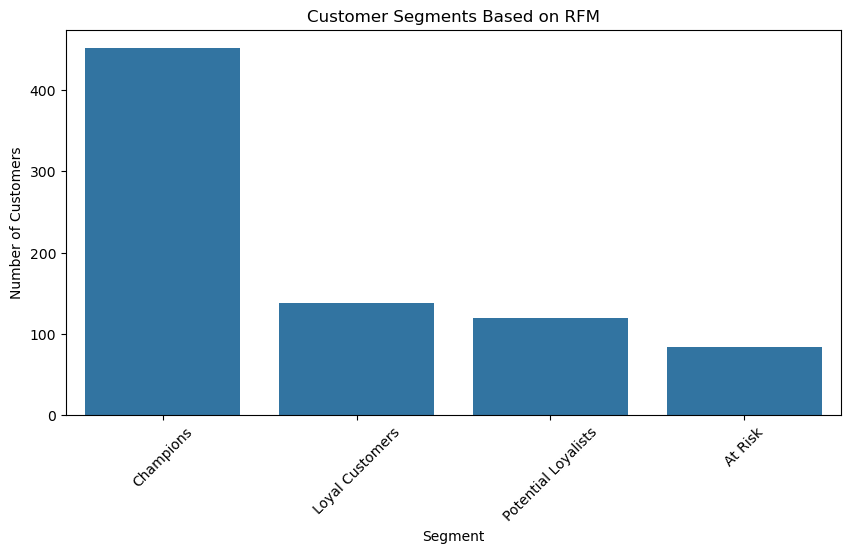

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index)
plt.title('Customer Segments Based on RFM')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()


#### Predict New Data :
##### Decision Tree Model : Classifier

In [10]:
rfm.head()

,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score,Segment
0,AA-10315,185,11,5563.560,2,3,5,235,10,Champions
1,AA-10375,20,15,1056.390,5,4,2,542,11,Champions
2,AA-10480,260,12,1790.512,1,3,3,133,7,Loyal Customers
3,AA-10645,56,18,5086.935,3,4,5,345,12,Champions
4,AB-10015,416,6,886.156,1,1,1,111,3,At Risk


In [11]:
rfm.columns

Index(['Customer ID', 'Recency', 'Frequency', 'Monetary', 'R_Score', 'F_Score',
       'M_Score', 'RFM_Segment', 'RFM_Score', 'Segment'],
      dtype='object')

In [12]:
X = rfm[['Recency', 'Frequency', 'Monetary', 'RFM_Segment', 'RFM_Score']]
X

,Recency,Frequency,Monetary,RFM_Segment,RFM_Score
0,185,11,5563.560,235,10
1,20,15,1056.390,542,11
2,260,12,1790.512,133,7
3,56,18,5086.935,345,12
4,416,6,886.156,111,3
...,...,...,...,...,...
788,44,28,2374.658,453,12
789,5,8,5454.350,525,12
790,10,12,6720.444,535,13
791,55,31,8025.707,355,13


In [13]:
Y = rfm['Segment']
Y

0                Champions
1                Champions
2          Loyal Customers
3                Champions
4                  At Risk
              ...         
788              Champions
789              Champions
790              Champions
791              Champions
792    Potential Loyalists
Name: Segment, Length: 793, dtype: object

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size= 0.3, random_state = 42)

In [16]:
X_Train.shape, X_Test.shape, Y_Train.shape, Y_Test.shape

((555, 5), (238, 5), (555,), (238,))

In [17]:
from sklearn.tree import DecisionTreeClassifier

In [18]:
model = DecisionTreeClassifier()
model.fit(X_Train, Y_Train)

DecisionTreeClassifier()

In [19]:
Y_Pred = model.predict(X_Test)
Y_Pred

array(['Loyal Customers', 'Champions', 'Potential Loyalists',
       'Potential Loyalists', 'Loyal Customers', 'Loyal Customers',
       'Champions', 'Champions', 'Loyal Customers', 'Loyal Customers',
       'At Risk', 'Champions', 'Potential Loyalists', 'Champions',
       'Loyal Customers', 'Champions', 'Loyal Customers',
       'Potential Loyalists', 'Champions', 'Potential Loyalists',
       'Champions', 'Champions', 'Potential Loyalists', 'Champions',
       'Loyal Customers', 'Loyal Customers', 'Champions', 'Champions',
       'Champions', 'Champions', 'Champions', 'Champions', 'Champions',
       'Potential Loyalists', 'Potential Loyalists',
       'Potential Loyalists', 'Loyal Customers', 'Champions', 'At Risk',
       'At Risk', 'At Risk', 'Loyal Customers', 'Potential Loyalists',
       'At Risk', 'Champions', 'Potential Loyalists', 'Champions',
       'Champions', 'Champions', 'Potential Loyalists', 'Loyal Customers',
       'Champions', 'Loyal Customers', 'Potential Loyalis

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [21]:
confusion_matrix(Y_Test, Y_Pred)

array([[ 25,   0,   0,   0],
       [  0, 147,   0,   0],
       [  0,   0,  34,   0],
       [  0,   0,   0,  32]], dtype=int64)

In [22]:
accuracy_score(Y_Test, Y_Pred)

1.0

In [24]:
import pandas as pd

# Load the dataset
test_df = pd.read_csv("Superstore_Data.csv")
test_df.head()

,Row ID,Order ID,Order Date,Year,Ship Date,Ship Mode,Customer ID,CxCode,Customer Name,Order ID.1,...,Category,Sub-Category,Products,Sales,Cx_Category,Quantity,Qty_Status,New_Discount,Discount,Profit
0,1.0,CA-2016-152156,08-11-2016,2016.0,11-11-2016,Second Class,CG-12520,CG,Claire Gute,CA-2016-152156,...,Furniture,Bookcases,Bookcases : Riverside Palais Royal Lawyers Boo...,261.9600,General Cx,2.0,Less Quantity,261.96000,0.00,41.9136
1,2.0,CA-2016-152156,08-11-2016,2016.0,11-11-2016,Second Class,CG-12520,CG,Claire Gute,CA-2016-152156,...,Furniture,Chairs,Chairs : Hon Deluxe Fabric Upholstered Stackin...,731.9400,Loyal Cx,3.0,Less Quantity,731.94000,0.00,219.5820
2,3.0,CA-2016-138688,12-06-2016,2016.0,16-06-2016,Second Class,DV-13045,DV,Darrin Van Huff,CA-2016-138688,...,Office Supplies,Labels,Labels : Self-Adhesive Address Labels for Type...,14.6200,General Cx,2.0,Less Quantity,11.69600,0.00,6.8714
3,4.0,US-2015-108966,11-10-2015,2015.0,18-10-2015,Standard Class,SO-20335,SO,Sean O'Donnell,US-2015-108966,...,Furniture,Tables,Tables : Bretford CR4500 Series Slim Rectangul...,957.5775,Loyal Cx,5.0,High Quantity,478.78875,0.45,-383.0310
4,5.0,US-2015-108966,11-10-2015,2015.0,18-10-2015,Standard Class,SO-20335,SO,Sean O'Donnell,US-2015-108966,...,Office Supplies,Storage,Storage : Eldon Fold 'N Roll Cart System,22.3680,General Cx,2.0,Less Quantity,17.89440,0.20,2.5164


In [25]:
X_test_df = RFM_Cx_Label_Classffier(test_df)

C:\Users\aflah\AppData\Local\Temp\ipykernel_4556\4190231877.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True, errors='coerce')
C:\Users\aflah\AppData\Local\Temp\ipykernel_4556\4190231877.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['Customer ID', 'Order Date', 'Sales'], inplace=True)


In [26]:
model.predict(X_test_df)

array(['Champions', 'Champions', 'Loyal Customers', 'Champions',
       'At Risk', 'Champions', 'Champions', 'Champions', 'Champions',
       'Loyal Customers', 'Loyal Customers', 'At Risk', 'Champions',
       'Champions', 'At Risk', 'Champions', 'Champions', 'At Risk',
       'Loyal Customers', 'At Risk', 'Loyal Customers',
       'Potential Loyalists', 'Champions', 'Potential Loyalists',
       'Champions', 'Potential Loyalists', 'Champions', 'Champions',
       'Champions', 'Champions', 'Loyal Customers', 'Champions',
       'Potential Loyalists', 'Loyal Customers', 'Champions', 'Champions',
       'Champions', 'Champions', 'Loyal Customers', 'Potential Loyalists',
       'Loyal Customers', 'Champions', 'At Risk', 'Champions',
       'Champions', 'Potential Loyalists', 'Potential Loyalists',
       'Loyal Customers', 'Champions', 'At Risk', 'Champions',
       'Champions', 'Champions', 'Potential Loyalists', 'Champions',
       'Potential Loyalists', 'Champions', 'Loyal Customers',